### 1.Import Library

In [8]:
import sys
project_path = r"D:/DaiHoc/machinelearning/TLCN/DoAnTotNghiep_chat_bot/"
sys.path.append(project_path)
from source.function.utils_result import RAG
from source.search.utils_search import Qdrant_Utils
from source.rerank.utils_rerank import Rerank_Utils  
from source.model.embedding_model import Sentences_Transformer_Embedding
from source.model.extract_model import Bert_Extract
from source.model.generate_model import Gemini
from source.model.rerank_model import Cohere
from source.data.vectordb.qdrant import Qdrant_Vector
from source.core.config import Settings
from source.generate.generate import Gemini_Generate
from source.extract.utils_extract import Extract_Information
from source.schema.chatbot_querry import ChatbotQuery
setting=Settings()
gemini=Gemini(setting)
cohere=Cohere(setting)
bert=Bert_Extract(setting)
sentences_transformer_embedding=Sentences_Transformer_Embedding(setting)
qdrant=Qdrant_Vector(setting,sentences_transformer_embedding)
rerank_Utils=Rerank_Utils(cohere)
extract_Utils= Extract_Information(bert)
generate_Utils=Gemini_Generate(gemini,setting)
qdrant_Utils=Qdrant_Utils(qdrant, generate_Utils)
rag=RAG(generate_Utils,extract_Utils,qdrant_Utils,rerank_Utils,setting,sentences_transformer_embedding)
import pandas as pd
from tqdm import tqdm
import google.generativeai as genai 
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from rouge_score import rouge_scorer

### 2. Đọc dữ liệu từ tệp Excel:

In [3]:
import pandas as pd

# Đọc tệp Excel
df = pd.read_excel('../data_danhgia_module_router_generate/eval_query_generate.xlsx')

# Kiểm tra các cột trong DataFrame
print(df.columns)


Index(['Original Query', 'Query 1', 'Query 2', 'Query 3'], dtype='object')


### 3. Tính độ tương đồng Cosine sử dụng Embedding Gemini

In [4]:
setting=Settings()

In [5]:
genai.configure(api_key=gemini.key_manager.get_next_key())

def get_gemini_embedding(text: str,
                         model_name: str = "models/text-embedding-004") -> list[float]:
    res = genai.embed_content(
        model=model_name,
        content=text
    )
    return res["embedding"]
### 4. Tính cosine similarity giữa Original Query và các Query sinh ra
cosine_similarities = []

for i in tqdm(range(len(df))):
    try:
        original_emb = get_gemini_embedding(df.loc[i, 'Original Query'])
        sims = []
        for j in range(1, 4):
            query_emb = get_gemini_embedding(df.loc[i, f'Query {j}'])
            sim = cosine_similarity(
                np.array(original_emb).reshape(1, -1),
                np.array(query_emb).reshape(1, -1)
            )[0][0]
            sims.append(sim)
        cosine_similarities.append(sims)
    except Exception as e:
        print(f"Lỗi tại dòng {i}: {e}")
        cosine_similarities.append([0, 0, 0])  # Gán 0 nếu lỗi

### 5. Phân bố điểm trung bình Cosine Similarity của từng data point
avg_cosine_per_point = [sum(sims) / 3 for sims in cosine_similarities]
# Hiển thị giá trị trung bình cosine similarity toàn bộ
overall_avg_cosine = sum(avg_cosine_per_point) / len(avg_cosine_per_point)
print(f"\nTrung bình toàn bộ Cosine Similarity: {overall_avg_cosine:.4f}")

  0%|          | 0/1075 [00:00<?, ?it/s]

100%|██████████| 1075/1075 [30:17<00:00,  1.69s/it]


Trung bình toàn bộ Cosine Similarity: 0.9352


> Phân bố điểm trung bình cosine similarity của từng data point

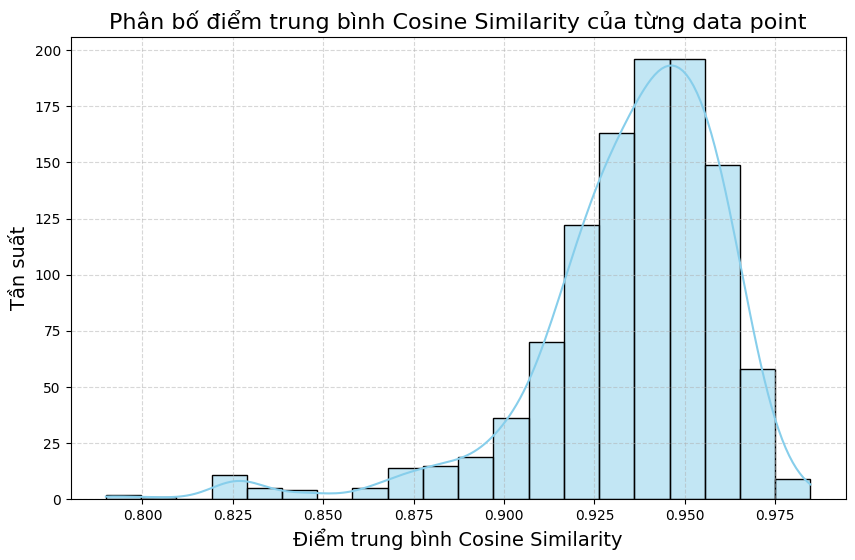

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tính điểm trung bình Cosine Similarity cho từng data point
avg_cosine_per_point = [sum(sims) / len(sims) for sims in cosine_similarities]

# Thiết lập kích thước biểu đồ
plt.figure(figsize=(10, 6))

# Vẽ biểu đồ phân bố
sns.histplot(avg_cosine_per_point, bins=20, kde=True, color='skyblue')
plt.title('Phân bố điểm trung bình Cosine Similarity của từng data point', fontsize=16)
plt.xlabel('Điểm trung bình Cosine Similarity', fontsize=14)
plt.ylabel('Tần suất', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
# Hiển thị biểu đồ
plt.show()

### 4. Tính điểm ROUGE-L:

In [9]:
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)

# Tính điểm ROUGE-L
rouge_scores = []
for i in range(len(df)):
    scores = []
    for j in range(1, 4):
        score = scorer.score(df['Original Query'][i], df[f'Query {j}'][i])['rougeL'].fmeasure
        scores.append(score)
    rouge_scores.append(scores)

# Tính trung bình ROUGE-L score
avg_rouge = sum([sum(scores) for scores in rouge_scores]) / (len(df) * 3)
print(f"\nTrung bình ROUGE-L score: {avg_rouge:.4f}")


Trung bình ROUGE-L score: 0.5829


> Phân bố điểm trung bình cosine similarity của từng data point

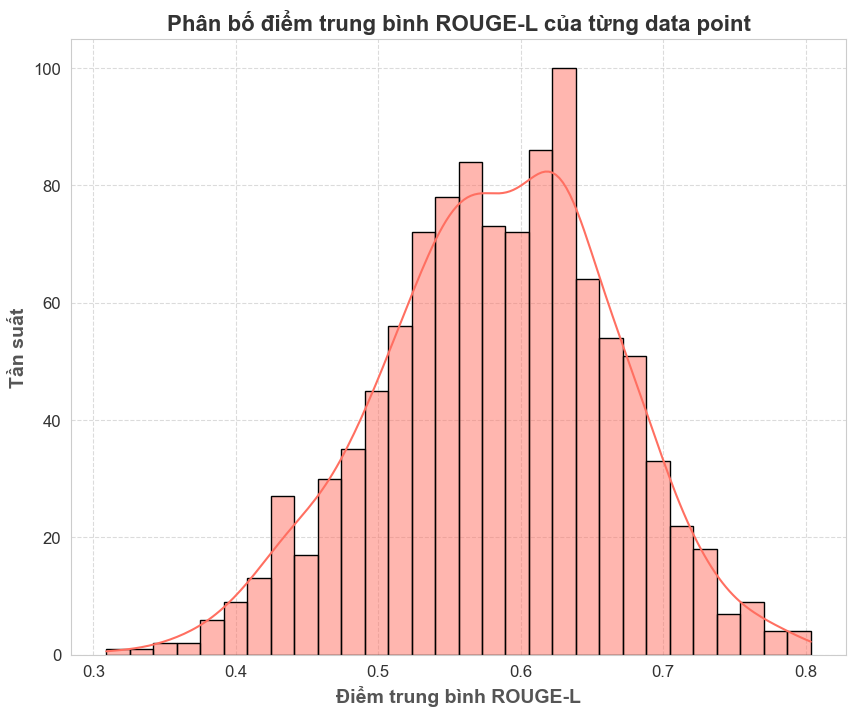

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Giả định bạn đã có dữ liệu avg_rouge_per_point từ trước
avg_rouge_per_point = [sum(scores) / 3 for scores in rouge_scores]

plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
sns.histplot(avg_rouge_per_point, kde=True, color='#FF6F61', bins=30, edgecolor='black')  # Màu cam hồng nổi bật
plt.title("Phân bố điểm trung bình ROUGE-L của từng data point", fontsize=16, fontweight='bold', color='#333333')
plt.xlabel("Điểm trung bình ROUGE-L", fontsize=14, fontweight='bold', color='#555555')
plt.ylabel("Tần suất", fontsize=14, fontweight='bold', color='#555555')
plt.xticks(fontsize=12, color='#333333')
plt.yticks(fontsize=12, color='#333333')
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.show()
